# Finding trending issues on the SF311 dataset

In [36]:
import pandas as pd
%matplotlib inline

## The time window to bucket samples
TIME_RANGE = '30min'

## File path
DATAPATH = "SF311_simplified.csv"


#### Turn a raw CSV file into a time series we can model using some utils from moda

In [2]:
from moda.dataprep.raw_to_ts import raw_to_ts
from moda.dataprep.ts_to_range import ts_to_range

def raw_to_timeseries(datapath, time_range='30min', nrows=None, min_date=None, max_date=None, save_files=False):
    """
    Take a raw data with timestamps (date column), categories (category column) and additional columns,
    and turn it into a ranged time-series: Group the original raw data by time interval (time_range) and category.
    Result is the number of samples per category in each time range.
    :param datapath: the path to the csv file
    :param time_range: the time_range according to which the data is grouped by
    :param nrows: limits the number of rows read from the csv
    :param min_date: filters out ranges prior to min_date
    :param max_date: filters out ranges after max_date
    :param save_files: Whether to save intermediate csvs
    :returns a pd.DataFrame with one value per time_range and category.
    This value is the number of samples within this range for a specific category


    """
    
    if datapath is None:
        raise ValueError("datapath should contain the path to a CSV file")
    
    if nrows is None:
        raw = pd.read_csv(datapath, usecols=['Opened', 'Category'])
    else:
        raw = pd.read_csv(datapath, usecols=['Opened', 'Category'], nrows=nrows)

    raw = raw.rename(columns={'Opened': 'date', 'Category': 'category'})

    # Create a time series dataframe
    ts = raw_to_ts(raw, min_date=min_date, max_date=max_date)

    # Divide time series to ranges and categories
    ranged_ts = ts_to_range(ts, time_range=time_range)

    if save_files:
        if nrows is None:
            ts.to_csv("ts.csv")
            ranged_ts.to_csv("ranged_ts.csv")
        else:
            ts.to_csv("ts_" + str(nrows) + "_rows.csv")
            ranged_ts.to_csv("ranged_ts_" + str(nrows) + "_rows.csv")
    return ranged_ts

### Read a sample from the SF 311 data
Limiting the number of rows as this is a pretty big file

In [ ]:
ranged_ts = raw_to_timeseries(DAPATH,time_range=TIME_RANGE,nrows=500000,max_date="2010-01-01")

#### A time series in moda has a MultiIndex, comprised of the date and the category.


In [ ]:
print(len(ranged_ts))
ranged_ts.head()

In [12]:
#Let's look which categories appear the most. We remove the index just for the EDA
flat = ranged_ts.reset_index()

#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
from dfply import *

categories = flat >> group_by(X.category) >> \
    summarise(value = np.sum(X.value)) >> \
    ungroup() >> \
    arrange(X.value,ascending=False)


categories.head(10)

,category,value
84,Street and Sidewalk Cleaning,62647
73,Graffiti,44103
79,SFHA Requests,18077
77,MUNI Feedback,15884
1,Abandoned Vehicle,15147
74,Homeless Concerns,7937
85,Tree Maintenance,6573
80,Sewer Issues,6499
76,Litter Receptacles,5904
82,Sign Repair,5788


## Most discussed categories

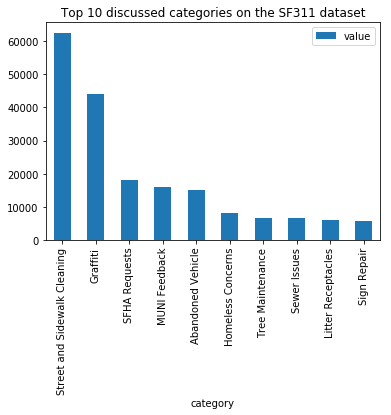

In [11]:
categories.head(10).plot(kind='bar',x='category',title="Top 10 discussed categories on the SF311 dataset")

## Time series inspection
### Selecting the biggest category, Street and Sidewalk Cleaning, just for inspection

In [13]:
street_cleaning = flat[flat['category']=='Street and Sidewalk Cleaning'].drop(columns='category')
street_cleaning = street_cleaning[street_cleaning['date'] < '2008-10-01']
street_cleaning.tail()

,date,value
15708,2008-09-30 19:30:00,1
15713,2008-09-30 20:30:00,1
15715,2008-09-30 21:00:00,2
15717,2008-09-30 21:30:00,1
15722,2008-09-30 22:30:00,2


In [14]:
len(street_cleaning)

2817

### Time series plot

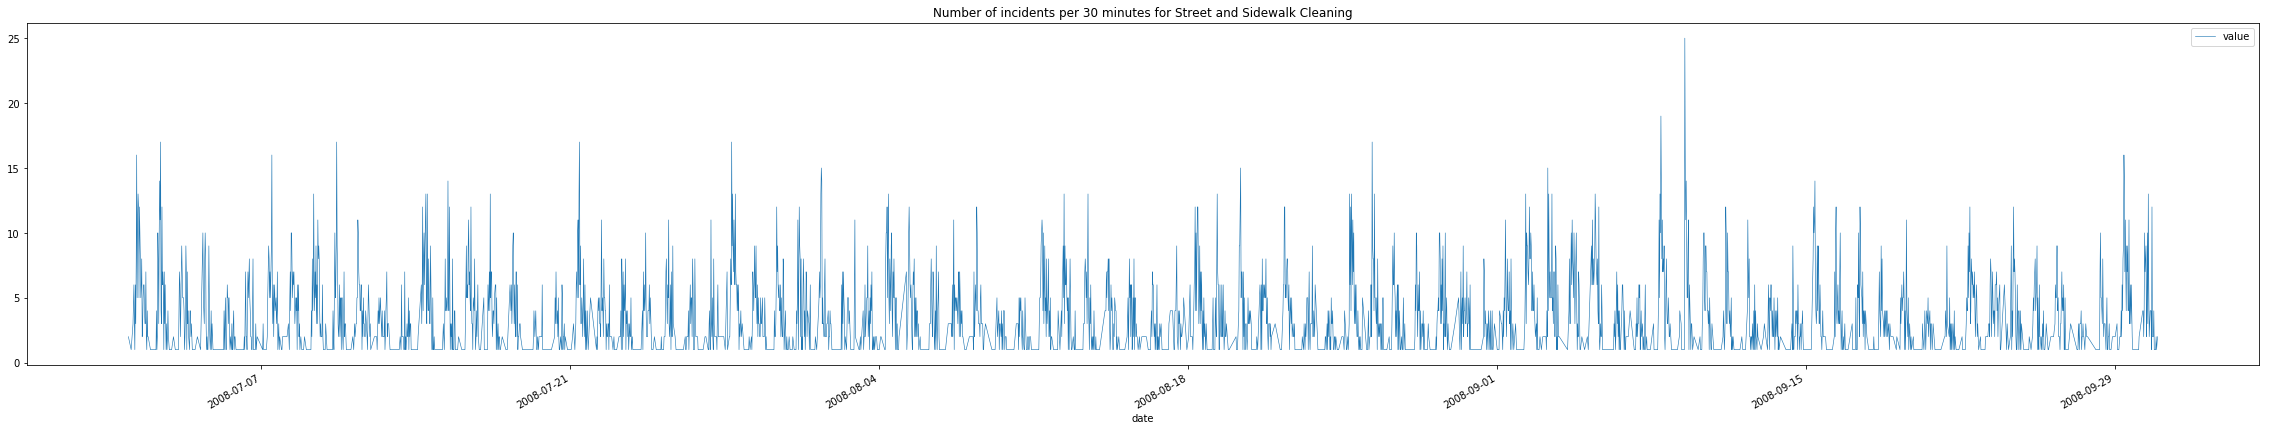

In [35]:
street_cleaning.plot(kind='line',x='date',y='value',figsize=(40,7),linewidth=0.6, title = "Number of incidents per 30 minutes for Street and Sidewalk Cleaning")

# Unsupervised anomaly detection on the street_cleaning using LSTM on Keras

In [ ]:
## Train test split
from moda.